In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/source-based-news-classification/news_articles.csv


In [11]:
# --- 1. Load and Inspect Data ---
print("Loading data...")
# Load the dataset
try:
    df = pd.read_csv('/kaggle/input/source-based-news-classification/news_articles.csv')
except FileNotFoundError:
    print("Error: 'news_articles.csv' not found.")
    exit()

print("Initial data shape:", df.shape)

Loading data...
Initial data shape: (2096, 12)


In [12]:
# --- 2. Data Cleaning and Preprocessing ---
print("\nCleaning and preprocessing data...")

# Drop rows where essential columns are missing
df.dropna(subset=['text', 'title', 'label'], inplace=True)

# Filter the DataFrame to only include 'Real' and 'Fake' news
df = df[df['label'].isin(['Real', 'Fake'])].copy()

# Map labels to numerical values
df['label_numeric'] = df['label'].map({'Fake': 1, 'Real': 0})

print("Data shape after cleaning:", df.shape)
if df.empty:
    print("Error: No data with 'Real' or 'Fake' labels found. Exiting.")
    exit()


Cleaning and preprocessing data...
Data shape after cleaning: (2050, 13)


In [13]:
# --- 3. Feature Engineering ---
print("\nPerforming feature engineering...")

# a. Text length features
df['text_length'] = df['text'].str.len()
df['title_length'] = df['title'].str.len()

# b. Word count features
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))

# c. Domain from URL
df['site_url'] = df['site_url'].fillna('unknown.com')
df['domain'] = df['site_url'].apply(lambda url: urlparse(url).netloc)

# d. Stylistic features
df['title_num_caps'] = df['title'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
df['text_num_caps'] = df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
df['title_num_special_chars'] = df['title'].apply(lambda x: len(re.findall(r'[!?]', x)))
df['text_num_special_chars'] = df['text'].apply(lambda x: len(re.findall(r'[!?]', x)))

# e. Combine text features for vectorizer
df['combined_text'] = df['title'].fillna('') + " " + df['text'].fillna('') + " " + df['domain'].fillna('')

print("Engineered features have been created.")


Performing feature engineering...
Engineered features have been created.


In [14]:
# --- 4. Prepare Data for Modeling ---
print("\nPreparing data for the model...")

# Define features (X) and target (y)
features = [
    'text_length',
    'title_length',
    'text_word_count',
    'title_word_count',
    'hasImage',
    'title_num_caps',
    'text_num_caps',
    'title_num_special_chars',
    'text_num_special_chars'
]
y = df['label_numeric']

# Split data into training and testing sets based on the full dataframe
X_train_df, X_test_df, y_train, y_test = train_test_split(
    df, y, test_size=0.25, random_state=42, stratify=y
)

# Create numerical feature sets for train and test
X_train_num = X_train_df[features].astype(float)
X_test_num = X_test_df[features].astype(float)

print(f"Training set size: {X_train_df.shape[0]} samples")
print(f"Testing set size: {X_test_df.shape[0]} samples")


Preparing data for the model...
Training set size: 1537 samples
Testing set size: 513 samples


In [15]:
# --- 5. Text Vectorization (TF-IDF) ---
print("\nVectorizing text data with TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit on training data and transform both train and test data
X_train_text = tfidf_vectorizer.fit_transform(X_train_df['combined_text'])
X_test_text = tfidf_vectorizer.transform(X_test_df['combined_text'])


Vectorizing text data with TF-IDF...


In [16]:
# --- 6. Combine Numerical and Text Features ---
print("Combining text and numerical features...")
X_train = hstack([X_train_text, X_train_num.values])
X_test = hstack([X_test_text, X_test_num.values])

# --- 7. Model Training (Using LightGBM) ---
print("\nTraining the LightGBM Classifier...")
model = lgb.LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31)
model.fit(X_train, y_train)
print("Model training complete.")

Combining text and numerical features...

Training the LightGBM Classifier...
[LightGBM] [Info] Number of positive: 969, number of negative: 568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124147
[LightGBM] [Info] Number of data points in the train set: 1537, number of used features: 4669
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.630449 -> initscore=0.534143
[LightGBM] [Info] Start training from score 0.534143
Model training complete.



Evaluating the model...

Model Accuracy: 0.8129

Classification Report:
              precision    recall  f1-score   support

        Real       0.80      0.66      0.72       190
        Fake       0.82      0.90      0.86       323

    accuracy                           0.81       513
   macro avg       0.81      0.78      0.79       513
weighted avg       0.81      0.81      0.81       513


Confusion Matrix:
[[125  65]
 [ 31 292]]


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:1218: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


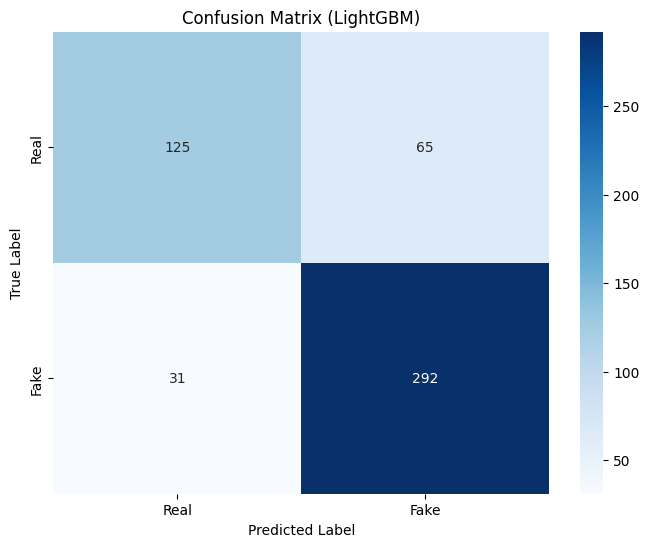

In [17]:
# --- 8. Model Evaluation ---
print("\nEvaluating the model...")
predictions = model.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['Real', 'Fake']))

# Print and visualize confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (LightGBM)')
plt.show()

In [ ]:
# --- 9. Save Results ---
print("\nSaving prediction results to 'prediction_results_lgbm.csv'...")

# Create a copy of the test dataframe to store results
results_df = X_test_df.copy()

# Map numeric predictions back to text labels ('Fake' for 1, 'Real' for 0)
results_df['pred_label'] = pd.Series(predictions, index=results_df.index).map({1: 'Fake', 0: 'Real'})

# Get the list of original columns from the input file
original_input_cols = [
    'author', 'published', 'title', 'text', 'language', 'site_url',
    'main_img_url', 'type', 'hasImage'
]

# Create the final list of columns for the output file
output_cols = [col for col in original_input_cols if col in results_df.columns] + ['pred_label']

# Select the desired columns and save to a new CSV file
output_df = results_df[output_cols]
output_df.to_csv('prediction_results_lgbm.csv', index=False)

print("Results saved successfully to prediction_results_lgbm.csv")